In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization,GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

image_dir = "/kaggle/input/k-hair/images_batch_3"
csv_path = "/kaggle/input/k-hairtype/image_titles.csv"
df = pd.read_csv(csv_path)
df['Hairlength'] = df['Hairlength'].astype(int)
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20

2025-08-05 07:49:36.224691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754380176.441324      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754380176.503397      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def load_and_preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0  
    return img, label

In [3]:
def create_dataset(df, image_dir, shuffle=True):
    image_paths = [os.path.join(image_dir, fname) for fname in df['Image_Title']]
    labels = df['Hairlength'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

In [17]:
def build_model():
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)) 
    x = get_data_augmentation()(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.6)(x)

    x = Dense(128, activation='relu')(x)
    hairlength_output = Dense(1, activation='sigmoid',name='hairlength')(x)

    model = Model(inputs=inputs, outputs=hairlength_output)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    model.summary()
    return model

In [5]:
def get_data_augmentation():
    data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    ])
    return data_augmentation

Training samples: 17516
Validation samples: 3754
Test samples: 3754


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 256)            │             

 Total params: 490,177 (1.87 MB)

 Trainable params: 488,705 (1.86 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/20


E0000 00:00:1754385501.787464      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_23_1/dropout_55_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7183 - loss: 0.6169
Epoch 1: val_accuracy improved from -inf to 0.65210, saving model to /kaggle/working/hairlengthtask4.weights.h5
548/548 ━━━━━━━━━━━━━━━━━━━━ 103s 171ms/step - accuracy: 0.7184 - loss: 0.6167 - val_accuracy: 0.6521 - val_loss: 0.9349
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8751 - loss: 0.3527
Epoch 2: val_accuracy did not improve from 0.65210
548/548 ━━━━━━━━━━━━━━━━━━━━ 96s 170ms/step - accuracy: 0.8751 - loss: 0.3526 - val_accuracy: 0.5591 - val_loss: 9.8530
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9060 - loss: 0.2909
Epoch 3: val_accuracy improved from 0.65210 to 0.81087, saving model to /kaggle/working/hairlengthtask4.weights.h5
548/548 ━━━━━━━━━━━━━━━━━━━━ 96s 170ms/step - accuracy: 0.9060 - loss: 0.2908 - val_accuracy: 0.8109 - val_loss: 0.5992
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9105 - loss: 0.2847
Epoch 4: val_accurac

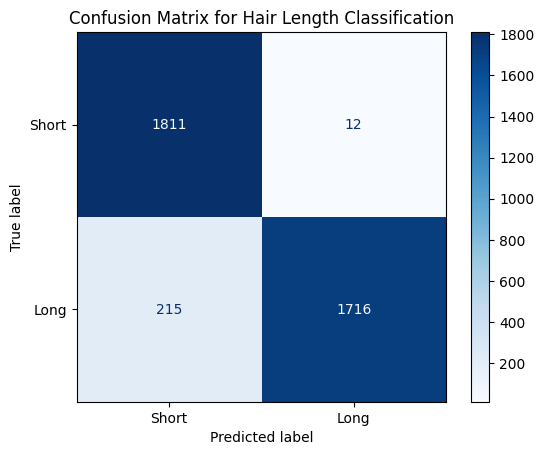

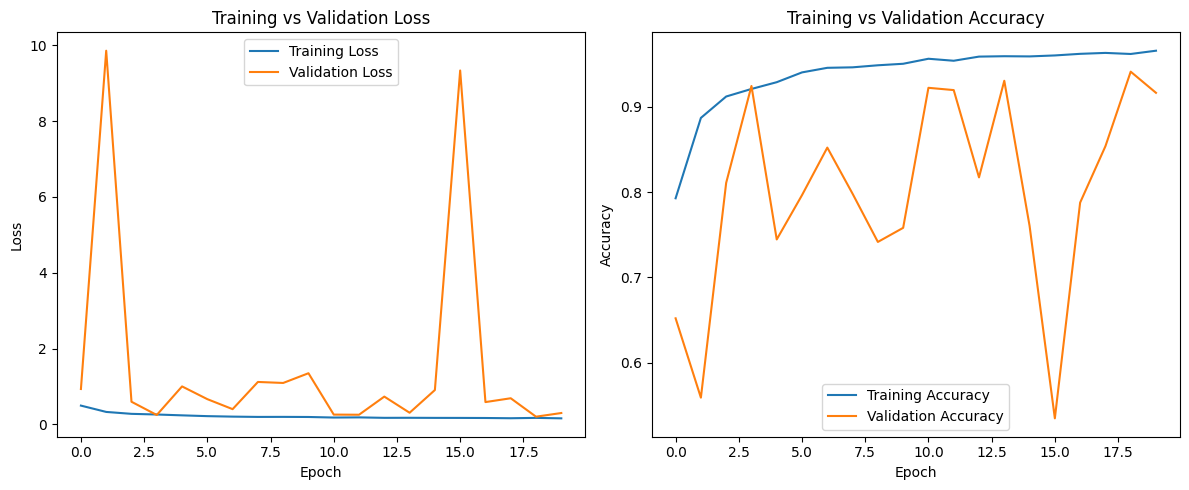

In [21]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Hairlength'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Hairlength'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
train_dataset = create_dataset(train_df, image_dir)
val_dataset = create_dataset(val_df, image_dir, shuffle=False)
test_dataset = create_dataset(test_df, image_dir, shuffle=False)


model = build_model()
checkpoint = ModelCheckpoint(
    "/kaggle/working/hairlengthtask4.weights.h5",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
)
history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint,early_stopping],
        verbose=1
)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

model.load_weights("/kaggle/working/hairlengthtask4.weights.h5")
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

y_pred = []
y_true = []
for images, labels in test_dataset:
    y_pred.extend(model.predict(images, verbose=0).flatten())
    y_true.extend(labels.numpy())
y_pred_binary = (np.array(y_pred) > 0.5).astype(int)
y_true = np.array(y_true)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)
cm = confusion_matrix(y_true, y_pred_binary)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

class_labels = ["Short", "Long"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Hair Length Classification")
plt.show()
model.save('/kaggle/working/hairlengthtask4.h5')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()